Author:  \
Davide Perozzi 1003768

# Project extension

In this experiment, we investigate how feature decorrelation impacts coefficients' variance while generating the same datasets with various seeds.
For each training phase is used a previous fixed seed.\
The graphs used fall into three categories: with no noise, with noise on feature 'D,' and with noise on all features.

The results show a reduction in coefficients' variance when training with decorrelated features compared to correlated ones across all models and graphs. The exception is the Stochastic Linear Regressor with the noise on all features of the graph, where an increase in variance is observed.

In [17]:
seeds = [42 * i for i in range(1, 26)]
num_data = 10000
epochs = 2
fixed_seed = 69

### Imports & functions

In [28]:
!pip install causalgen

In [29]:
import os
import random
import numpy as np
import torch
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from causalgen.generator import Generator
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from tqdm import tqdm
from keras.models import Sequential
from sklearn.tree import DecisionTreeRegressor
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  rng = np.random.default_rng(seed)
  torch.manual_seed(seed)
  tf.random.set_seed(1)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [30]:
# Compute the mean of the arrays and L1 and L2 norms of each array with respect to the mean array

def print_L1_L2(C_import, C_prime_import):
  mean_array = np.mean(C_import, axis=0)
  l1_norm = np.linalg.norm(C_import - mean_array, ord=1, axis=1)
  l2_norm = np.linalg.norm(C_import - mean_array, ord=2, axis=1)

  print("model C")
  print("L1 norm")
  print("mean:", np.mean(l1_norm))
  print("L2 norm")
  print("mean:", np.mean(l2_norm))
  print("\n")

  mean_array = np.mean(C_prime_import, axis=0)
  l1_norm_prime = np.linalg.norm(C_prime_import - mean_array, ord=1, axis=1)
  l2_norm_prime = np.linalg.norm(C_prime_import - mean_array, ord=2, axis=1)

  print("model C_prime")
  print("L1 norm")
  print("mean:", np.mean(l1_norm_prime))
  print("L2 norm")
  print("mean:", np.mean(l2_norm_prime))
  print("\n")

In [31]:
def plot_coefs(results):
  plt.figure(figsize=(5, 3))

  sns.set(style="whitegrid")
  ax = sns.barplot(data=results, estimator='mean', errorbar='sd')
  ax.set_ylabel('Values')
  ax.set_xlabel('Features')

  plt.show()

In [32]:
def plot_scores(x_axis, loss_history):
  plt.figure(figsize=(5, 3))
  plt.plot(x_axis, loss_history, marker='o')
  plt.xlabel('Seeds')
  plt.ylabel('Score')
  plt.title('Score over Seeds')
  plt.grid(True)
  plt.show()

In [33]:
def print_bold(text):
    bold_text = f"\033[1m{text}\033[0m"
    print(bold_text)

In [34]:
def compute_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=20,
      batch_size=32,
      verbose=0
      )

  df['C_new'] = model.predict(df[['A','B']], verbose=0)
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [35]:
def build_SLR():
  model = Sequential()
  model.add(Dense(1, input_dim=3, activation='linear'))
  sgd = SGD()
  model.compile(loss='mean_squared_error', optimizer=sgd)
  return model

def build_SDT(seed):
  model = DecisionTreeRegressor(splitter="random", random_state=seed)
  return model

In [36]:
def fit(model, dataset, epochs=None, C_prime=False):
    if C_prime:
        feature_columns = ['A', 'B', 'C_prime']
    else:
        feature_columns = ['A', 'B', 'C']

    if isinstance(model, DecisionTreeRegressor):
        model.fit(dataset[feature_columns], dataset['D'])
        y_pred = model.predict(dataset[feature_columns])
        score = r2_score(dataset['D'], y_pred)
        weights = model.feature_importances_
    else:
        if epochs is None:
            raise ValueError("Epochs parameter must be provided for Sequential models.")
        model.fit(dataset[feature_columns], dataset['D'], epochs=epochs, verbose=0)
        y_pred = model.predict(dataset[feature_columns], verbose=0)
        score = r2_score(dataset['D'], y_pred)
        weights = model.layers[0].get_weights()[0].flatten()

    return weights, score

In [37]:
def run_experiment(generator, epochs, fixed_seed, seeds, C_prime=False):

  slr_weights = []
  slr_scores_history = []
  sdt_weights = []
  sdt_scores_history = []

  for seed in tqdm(seeds, desc="Running experiment", unit="seed"):

    # set variable seed and build dataset
    set_reproducibility(seed)
    df = pd.DataFrame(generator(seed, num_data))
    if C_prime:
      df = compute_C_prime(df)

    # set fixed seed and build models
    set_reproducibility(fixed_seed)
    slr = build_SLR()
    sdt = build_SDT(fixed_seed)

    # train models
    weights, scores = fit(slr, df, epochs=epochs, C_prime=C_prime)
    slr_weights.append(weights)
    slr_scores_history.append(scores)

    weights, scores = fit(sdt, df, C_prime=C_prime)
    sdt_weights.append(weights)
    sdt_scores_history.append(scores)

  return slr_weights, slr_scores_history, sdt_weights, sdt_scores_history

## Graph

Graph with no noise.

In [ ]:
def generate_data(seed, num_data):

  dg = Generator(seed=seed)

  A = dg.normal(mu=0, sigma=1, name='A')

  B = dg.normal(mu=0, sigma=1, name='B')

  C = dg.descendant(A + B, name='C')

  D = dg.descendant(A + B + C, name='D')

  dg.generate(hidden=True)

  return dg.generate(num=num_data)

### Train with C

In [ ]:
slr_weights, slr_scores, sdt_weights, sdt_scores = run_experiment(generate_data, epochs, fixed_seed, seeds)

Running experiment: 100%|██████████| 25/25 [00:59<00:00,  2.40s/seed]


Stochastic Linear Regressor weights variance with C


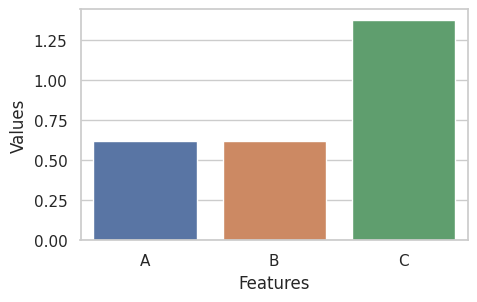



Stochastic Decision Tree weights variance with C


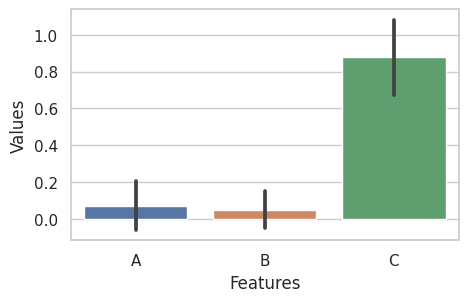

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C")
plot_coefs( pd.DataFrame(slr_weights, columns=["A", "B","C"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C")
plot_coefs( pd.DataFrame(sdt_weights, columns=["A", "B","C"]) )

We can notice zero variance on SLR and big variance on SDT.

### Train with C_prime

In [ ]:
slr_weights_C_prime, slr_scores_C_prime, sdt_weights_C_prime, sdt_scores_C_prime = run_experiment(generate_data, epochs, fixed_seed, seeds, C_prime=True)

Running experiment: 100%|██████████| 25/25 [05:44<00:00, 13.76s/seed]


Stochastic Linear Regressor weights variance with C_prime


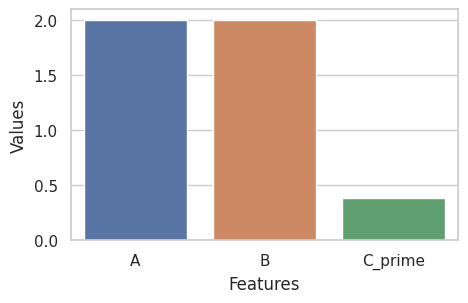



Stochastic Decision Tree weights variance with C_prime


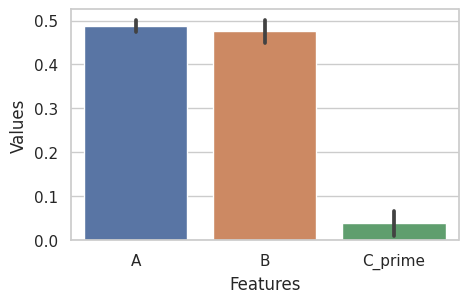

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C_prime")
plot_coefs( pd.DataFrame(slr_weights_C_prime, columns=["A", "B","C_prime"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C_prime")
plot_coefs( pd.DataFrame(sdt_weights_C_prime, columns=["A", "B","C_prime"]) )

We can notice zero variance on SLR and smaller variance on SDT.

### Comparison

Stochastic Linear Regressor scores with C


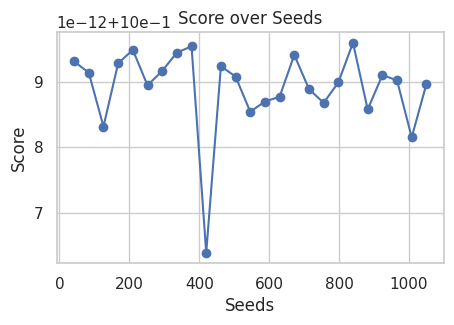

Stochastic Linear Regressor scores with C_prime


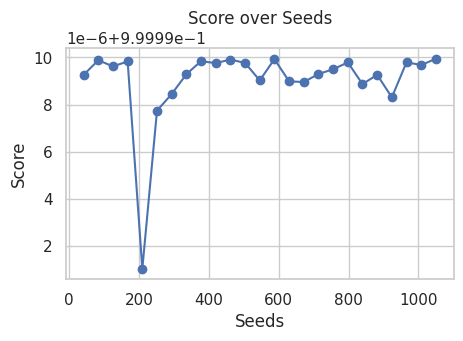

In [ ]:
print_bold("Stochastic Linear Regressor scores with C")
plot_scores(seeds, slr_scores)
print_bold("Stochastic Linear Regressor scores with C_prime")
plot_scores(seeds, slr_scores_C_prime)

In [ ]:
print_bold("Stochastic Linear Regressor")
print_L1_L2(slr_weights, slr_weights_C_prime)
print_bold("Stochastic Decision Tree")
print_L1_L2(sdt_weights, sdt_weights_C_prime)

Stochastic Linear Regressor
model C
L1 norm
mean: 1.1825562e-06
L2 norm
mean: 7.9442344e-07


model C_prime
L1 norm
mean: 0.0018402302
L2 norm
mean: 0.0015020042


Stochastic Decision Tree
model C
L1 norm
mean: 0.3499651798560063
L2 norm
mean: 0.2213187887942442


model C_prime
L1 norm
mean: 0.04720404953252981
L2 norm
mean: 0.030580882420330982




This comparison show a clear decrease in variance using **C_prime** for both SLR and SDT.

## Graph with noise

Graph with noise only on D.

In [ ]:
def generate_data_w_noise(seed, num_data):

  dg = Generator(seed=seed)

  A = dg.normal(mu=0, sigma=1, name='A')

  B = dg.normal(mu=0, sigma=1, name='B')

  C = dg.descendant(A + B, name='C')

  D = dg.descendant(A + B + C, noise=0.2, name='D')

  dg.generate(hidden=True)

  return dg.generate(num=num_data)

### Train with C

In [ ]:
slr_weights_w_noise, slr_scores_w_noise, sdt_weights_w_noise, sdt_scores_w_noise = run_experiment(generate_data_w_noise, epochs, fixed_seed, seeds)

Running experiment: 100%|██████████| 25/25 [01:33<00:00,  3.73s/seed]


Stochastic Linear Regressor weights variance with C


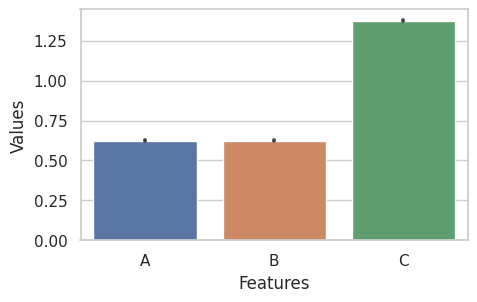



Stochastic Decision Tree weights variance with C


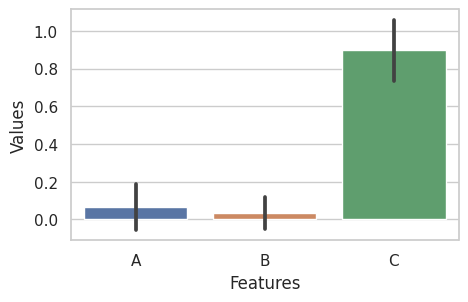

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C")
plot_coefs( pd.DataFrame(slr_weights_w_noise, columns=["A", "B","C"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C")
plot_coefs( pd.DataFrame(sdt_weights_w_noise, columns=["A", "B","C"]) )

We can notice small variance on SLR and big variance on SDT.

### Train with C_prime

In [ ]:
slr_weights_w_noise_C_prime, slr_scores_w_noise_C_prime, sdt_weights_w_noise_C_prime, sdt_scores_w_noise_C_prime = run_experiment(generate_data_w_noise, epochs, fixed_seed, seeds, C_prime=True)

Running experiment: 100%|██████████| 25/25 [08:11<00:00, 19.65s/seed]


Stochastic Linear Regressor weights variance with C_prime


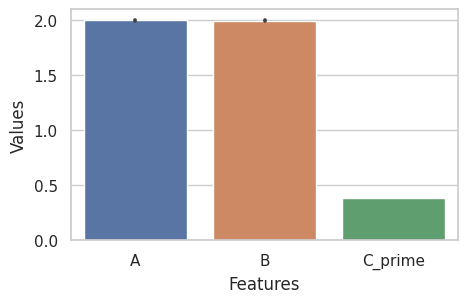



Stochastic Decision Tree weights variance with C_prime


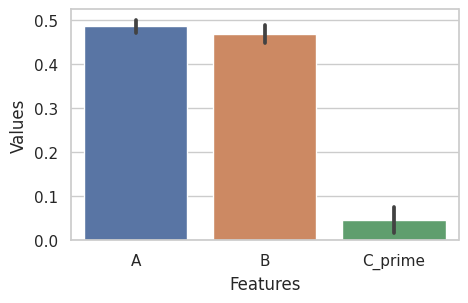

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C_prime")
plot_coefs( pd.DataFrame(slr_weights_w_noise_C_prime, columns=["A", "B","C_prime"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C_prime")
plot_coefs( pd.DataFrame(sdt_weights_w_noise_C_prime, columns=["A", "B","C_prime"]) )

We can notice smaller variance on both SLR and SDT.\
On SLR, **C_prime** has zero variance.

### Comparison

Stochastic Linear Regressor scores with C


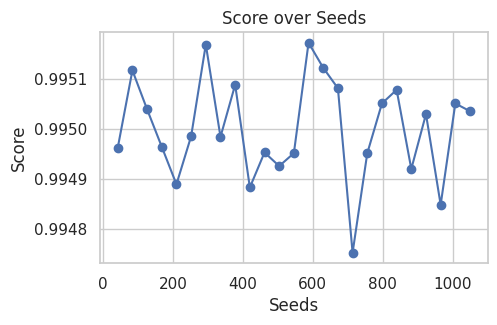

Stochastic Linear Regressor scores with C_prime


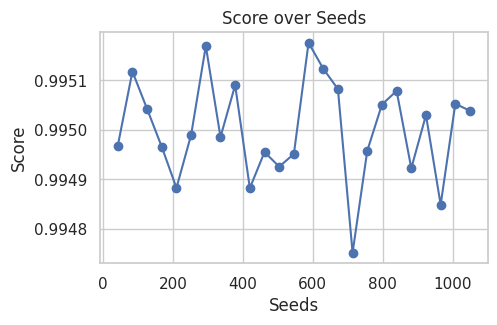

In [ ]:
print_bold("Stochastic Linear Regressor scores with C")
plot_scores(seeds, slr_scores_w_noise)
print_bold("Stochastic Linear Regressor scores with C_prime")
plot_scores(seeds, slr_scores_w_noise_C_prime)

In [ ]:
print_bold("Stochastic Linear Regressor")
print_L1_L2(slr_weights_w_noise, slr_weights_w_noise_C_prime)
print_bold("Stochastic Decision Tree")
print_L1_L2(sdt_weights_w_noise, sdt_weights_w_noise_C_prime)

Stochastic Linear Regressor
model C
L1 norm
mean: 0.006394198
L2 norm
mean: 0.004138955


model C_prime
L1 norm
mean: 0.006923343
L2 norm
mean: 0.0049422835


Stochastic Decision Tree
model C
L1 norm
mean: 0.28761773817246694
L2 norm
mean: 0.18660435317147483


model C_prime
L1 norm
mean: 0.05247872450014391
L2 norm
mean: 0.03334043123157067




This comparison show a decrease in variance using **C_prime** for SDT and a small increase for SLR.

## Graph with noise #2

Graph with noise on all the features.

In [ ]:
def generate_data_w_noise_2(seed, num_data):

  dg = Generator(seed=seed)

  A = dg.descendant(dg.normal(mu=0, sigma=1), noise=0.2, name='A')

  B = dg.descendant(dg.normal(mu=0, sigma=1), noise=0.2, name='B')

  C = dg.descendant(A + B, noise=0.2, name='C')

  D = dg.descendant(A + B + C, noise=0.2, name='D')

  dg.generate(hidden=True)

  return dg.generate(num=num_data)

### Train with C

In [ ]:
slr_weights_w_noise_2, slr_scores_w_noise_2, sdt_weights_w_noise_2, sdt_scores_w_noise_2 = run_experiment(generate_data_w_noise_2, epochs, fixed_seed, seeds)

Running experiment: 100%|██████████| 25/25 [00:55<00:00,  2.21s/seed]


Stochastic Linear Regressor weights variance with C


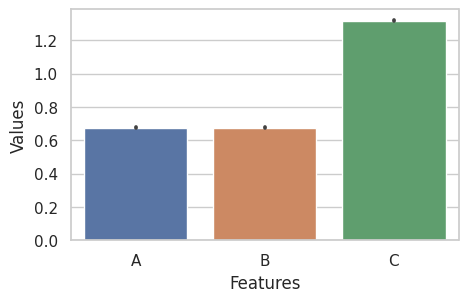



Stochastic Decision Tree weights variance with C


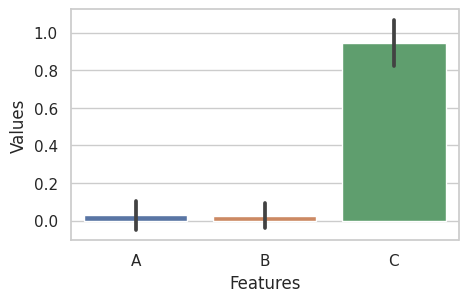

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C")
plot_coefs( pd.DataFrame(slr_weights_w_noise_2, columns=["A", "B","C"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C")
plot_coefs( pd.DataFrame(sdt_weights_w_noise_2, columns=["A", "B","C"]) )

Small variance on SLR and big variance on SDT.

### Train with C_prime

In [ ]:
slr_weights_w_noise_2_C_prime, slr_scores_w_noise_2_C_prime, sdt_weights_w_noise_2_C_prime, sdt_scores_w_noise_2_C_prime = run_experiment(generate_data_w_noise_2, epochs, fixed_seed, seeds, C_prime=True)

Running experiment: 100%|██████████| 25/25 [05:21<00:00, 12.86s/seed]


Stochastic Linear Regressor weights variance with C_prime


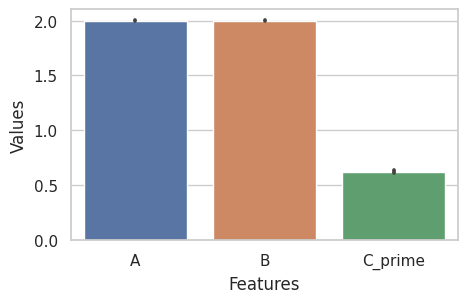



Stochastic Decision Tree weights variance with C_prime


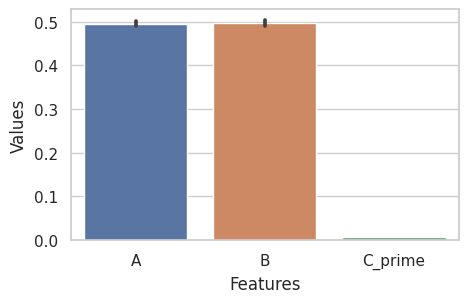

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C_prime")
plot_coefs( pd.DataFrame(slr_weights_w_noise_2_C_prime, columns=["A", "B","C_prime"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C_prime")
plot_coefs( pd.DataFrame(sdt_weights_w_noise_2_C_prime, columns=["A", "B","C_prime"]) )

Small variance on both SLR and SDT.

### Comparison

Stochastic Linear Regressor scores with C


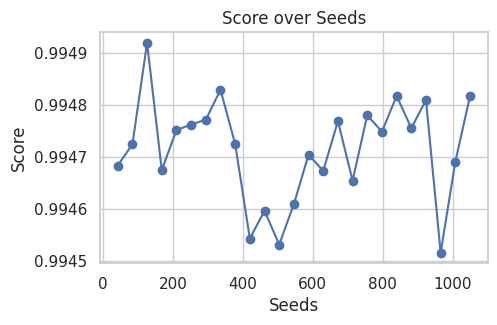

Stochastic Linear Regressor scores with C_prime


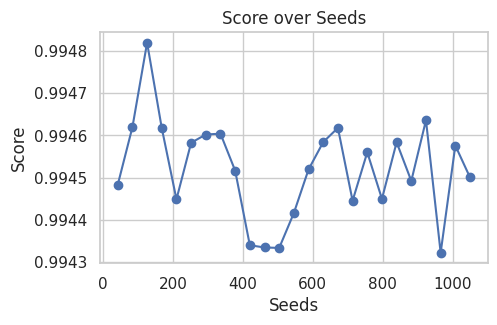

In [ ]:
print_bold("Stochastic Linear Regressor scores with C")
plot_scores(seeds, slr_scores_w_noise_2)
print_bold("Stochastic Linear Regressor scores with C_prime")
plot_scores(seeds, slr_scores_w_noise_2_C_prime)

In [ ]:
print_bold("Stochastic Linear Regressor")
print_L1_L2(slr_weights_w_noise_2, slr_weights_w_noise_2_C_prime)
print_bold("Stochastic Decision Tree")
print_L1_L2(sdt_weights_w_noise_2, sdt_weights_w_noise_2_C_prime)

Stochastic Linear Regressor
model C
L1 norm
mean: 0.0081017045
L2 norm
mean: 0.0054119034


model C_prime
L1 norm
mean: 0.018896904
L2 norm
mean: 0.0129083125


Stochastic Decision Tree
model C
L1 norm
mean: 0.1579563637883988
L2 norm
mean: 0.1001075326744437


model C_prime
L1 norm
mean: 0.009925553232823393
L2 norm
mean: 0.006924634346792175




This comparison show a clear decrease in variance using **C_prime** and elimination of variance in C for SDT but slight increase for SLR.


## Graph with noise #3

Graph with noise on all the features.

In [38]:
def generate_data_w_noise_3(seed, num_data):

  dg = Generator(seed=seed)

  A = dg.descendant(dg.normal(mu=0, sigma=1), name='A')

  B = dg.descendant(dg.normal(mu=0, sigma=1), name='B')

  C = dg.descendant(A + B, noise=0.8, name='C')

  D = dg.descendant(A + B + C, name='D')

  dg.generate(hidden=True)

  return dg.generate(num=num_data)

### Train with C

In [39]:
slr_weights_w_noise_3, slr_scores_w_noise_3, sdt_weights_w_noise_3, sdt_scores_w_noise_3 = run_experiment(generate_data_w_noise_3, epochs, fixed_seed, seeds)

Running experiment: 100%|██████████| 25/25 [00:43<00:00,  1.75s/seed]


Stochastic Linear Regressor weights variance with C


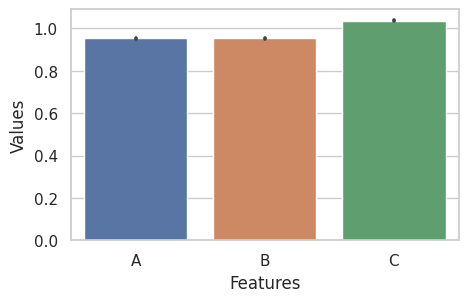



Stochastic Decision Tree weights variance with C


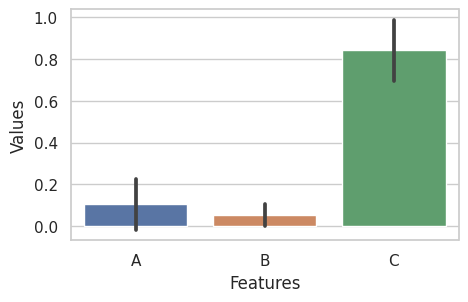

In [40]:
print_bold("Stochastic Linear Regressor weights variance with C")
plot_coefs( pd.DataFrame(slr_weights_w_noise_3, columns=["A", "B","C"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C")
plot_coefs( pd.DataFrame(sdt_weights_w_noise_3, columns=["A", "B","C"]) )

Small variance on SLR and big variance on SDT.

### Train with C_prime

In [41]:
slr_weights_w_noise_3_C_prime, slr_scores_w_noise_3_C_prime, sdt_weights_w_noise_3_C_prime, sdt_scores_w_noise_3_C_prime = run_experiment(generate_data_w_noise_3, epochs, fixed_seed, seeds, C_prime=True)

Running experiment: 100%|██████████| 25/25 [04:31<00:00, 10.84s/seed]


Stochastic Linear Regressor weights variance with C_prime


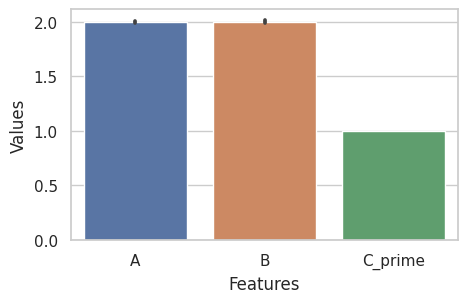



Stochastic Decision Tree weights variance with C_prime


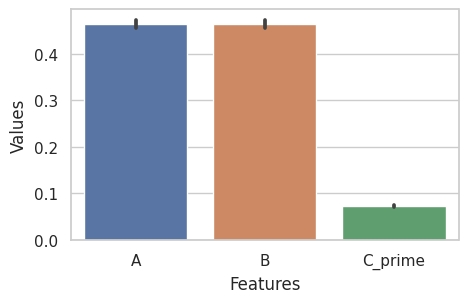

In [42]:
print_bold("Stochastic Linear Regressor weights variance with C_prime")
plot_coefs( pd.DataFrame(slr_weights_w_noise_3_C_prime, columns=["A", "B","C_prime"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C_prime")
plot_coefs( pd.DataFrame(sdt_weights_w_noise_3_C_prime, columns=["A", "B","C_prime"]) )

Small variance on both SLR and SDT.

### Comparison

Stochastic Linear Regressor scores with C


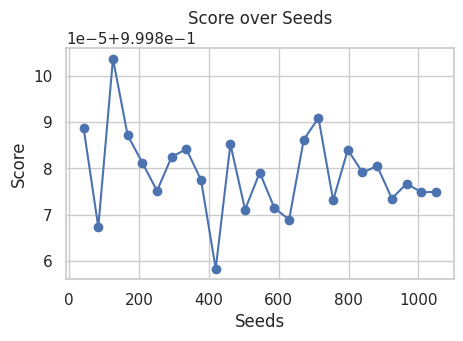

Stochastic Linear Regressor scores with C_prime


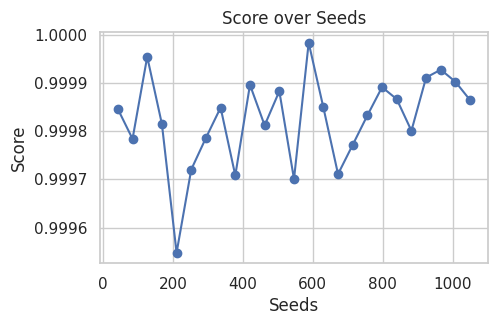

In [43]:
print_bold("Stochastic Linear Regressor scores with C")
plot_scores(seeds, slr_scores_w_noise_3)
print_bold("Stochastic Linear Regressor scores with C_prime")
plot_scores(seeds, slr_scores_w_noise_3_C_prime)

In [45]:
print_bold("Stochastic Linear Regressor")
print_L1_L2(slr_weights_w_noise_3, slr_weights_w_noise_3_C_prime)
print_bold("Stochastic Decision Tree")
print_L1_L2(sdt_weights_w_noise_3, sdt_weights_w_noise_3_C_prime)

Stochastic Linear Regressor
model C
L1 norm
mean: 0.0043460536
L2 norm
mean: 0.002667489


model C_prime
L1 norm
mean: 0.020999188
L2 norm
mean: 0.015791174


Stochastic Decision Tree
model C
L1 norm
mean: 0.25886999812978784
L2 norm
mean: 0.1717840686677361


model C_prime
L1 norm
mean: 0.014235455461739304
L2 norm
mean: 0.009341391435274925




This comparison show a clear decrease in variance using **C_prime** for SDT and elimination of variance in C for SLR.
